In [1]:
!pip install pyspark
!pip install python-dotenv

In [2]:
from pyspark.sql import SparkSession
from dotenv import load_dotenv
import os
from pyspark.sql.functions import col, date_format, count, round
from pyspark.sql.types import StructType, StructField, StringType, LongType, TimestampType

In [3]:
from google.colab import userdata


storage_account_name = userdata.get("AZURE_ACCOUNT_NAME")
storage_account_key = userdata.get("AZURE_STORAGE_KEY")

storage_container_name = "kaggle-datasets"
parquet_blob_name = "github-dataset-full.parquet"

In [4]:
# Creating Spark session
spark = SparkSession.builder \
    .appName("Read Parquet from Azure Blob Storage") \
    .config(f"spark.hadoop.fs.azure.account.key.{storage_account_name}.blob.core.windows.net", storage_account_key) \
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-azure:3.3.2,com.microsoft.azure:azure-storage:8.6.6") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()

# Remove garbage error texts
spark.sparkContext.setLogLevel("ERROR")

In [5]:
#Read the data from main file
users_df = spark.read.parquet(
    "wasbs://kaggle-datasets@matthewleffler1.blob.core.windows.net/clean_data/non_list_data"
)

In [6]:
#Read the data from main file
commits_df = spark.read.parquet(
    "wasbs://kaggle-datasets@matthewleffler1.blob.core.windows.net/clean_data/commit_list_data"
)

In [7]:
users_df.show()

+--------------------+--------------------+-------+----------+-------------------+--------------------+---------+---------+-------+--------+-------------+--------+--------------------+---------------+------------+------------+------------+-------------------+
|                 bio|                blog|commits|   company|         created_at|               email|followers|following|hirable|      id|is_suspicious|location|               login|           name|public_gists|public_repos|        type|         updated_at|
+--------------------+--------------------+-------+----------+-------------------+--------------------+---------+---------+-------+--------+-------------+--------+--------------------+---------------+------------+------------+------------+-------------------+
|                NULL|                    |   NULL|      NULL|2015-09-21 02:52:29|                NULL|        0|        0|   NULL|14413602|         true|    NULL|            llciq992|           NULL|           0|       

In [8]:
commits_df.show()

+--------+--------------+---------+-------------------+------------+-------------------+--------------------+--------------------+---------+--------------------+-------------+
| user_id|    user_login|author_id|          commit_at|committer_id|        generate_at|             message|    repo_description|  repo_id|           repo_name|repo_owner_id|
+--------+--------------+---------+-------------------+------------+-------------------+--------------------+--------------------+---------+--------------------+-------------+
|32464127|        aksor7| 32464127|2017-12-06 17:19:33|    32464127|2017-12-06 17:19:33|Added babyplot graph|                NULL|111622988|info201b-au17/AJJ...|     32108913|
|32464127|        aksor7| 32464127|2017-12-06 17:32:20|    32464127|2017-12-06 17:32:20|Updated introduct...|                NULL|111622988|info201b-au17/AJJ...|     32108913|
|32464127|        aksor7| 32464127|2017-12-06 17:36:42|    32464127|2017-12-06 17:36:42|Updated Introduct...|           

In [18]:
from pyspark.sql.functions import to_timestamp, date_format, year, count, round, col

# 1. Parse commit_at to timestamp
commits_df = commits_df.withColumn("commit_at", to_timestamp("commit_at", "yyyy-MM-dd"))

# 2. Filter valid timestamps and years 2008–2018
commits_df = commits_df.filter(
    col("commit_at").isNotNull() &
    (year("commit_at") >= 2008) &
    (year("commit_at") <= 2018)
)

# 3. Extract month name
commits_df = commits_df.withColumn("month", date_format("commit_at", "MMM"))

# 4. Total number of filtered commits
total_commits = commits_df.count()

# 5. Group by month and compute % of total
monthly_summary_df = commits_df.groupBy("month") \
    .agg(count("*").alias("monthly_commits")) \
    .withColumn("percent_of_total", round(col("monthly_commits") / total_commits * 100, 2)) \
    .orderBy("month")

monthly_summary_df.show(truncate=False)

+-----+---------------+----------------+
|month|monthly_commits|percent_of_total|
+-----+---------------+----------------+
|Apr  |11634964       |9.83            |
|Aug  |7932156        |6.7             |
|Dec  |9449900        |7.98            |
|Feb  |9697264        |8.19            |
|Jan  |9624784        |8.13            |
|Jul  |8964777        |7.57            |
|Jun  |10115304       |8.54            |
|Mar  |11789006       |9.96            |
|May  |11607901       |9.81            |
|Nov  |10065556       |8.5             |
|Oct  |9386982        |7.93            |
|Sep  |8113571        |6.85            |
+-----+---------------+----------------+



In [19]:
monthly_summary_df.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Sort [month#310 ASC NULLS FIRST], true, 0
   +- Exchange rangepartitioning(month#310 ASC NULLS FIRST, 200), ENSURE_REQUIREMENTS, [plan_id=596]
      +- Project [month#310, monthly_commits#353L, round(((cast(monthly_commits#353L as double) / 1.18382165E8) * 100.0), 2) AS percent_of_total#356]
         +- HashAggregate(keys=[month#310], functions=[count(1)])
            +- Exchange hashpartitioning(month#310, 200), ENSURE_REQUIREMENTS, [plan_id=592]
               +- HashAggregate(keys=[month#310], functions=[partial_count(1)])
                  +- Project [date_format(gettimestamp(gettimestamp(commit_at#39, yyyy-MM-dd, TimestampType, Some(Etc/UTC), false), yyyy-MM-dd, TimestampType, Some(Etc/UTC), false), MMM, Some(Etc/UTC)) AS month#310]
                     +- Filter (((isnotnull(gettimestamp(commit_at#39, yyyy-MM-dd, TimestampType, Some(Etc/UTC), false)) AND isnotnull(gettimestamp(gettimestamp(commit_at#39, yyyy-MM-dd, Timest

In [20]:
from pyspark.sql.functions import year

# Reuse the filtered commits_df (already between 2008–2018)
commits_per_year_df = commits_df.withColumn("year", year("commit_at")) \
    .groupBy("year") \
    .agg(count("*").alias("total_commits")) \
    .orderBy("year")

commits_per_year_df.show(truncate=False)

+----+-------------+
|year|total_commits|
+----+-------------+
|2008|127421       |
|2009|308620       |
|2010|640707       |
|2011|1537531      |
|2012|3149336      |
|2013|6043343      |
|2014|10397504     |
|2015|16574369     |
|2016|24616307     |
|2017|34788153     |
|2018|20198874     |
+----+-------------+



In [21]:
commits_per_year_df.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Sort [year#375 ASC NULLS FIRST], true, 0
   +- Exchange rangepartitioning(year#375 ASC NULLS FIRST, 200), ENSURE_REQUIREMENTS, [plan_id=686]
      +- HashAggregate(keys=[year#375], functions=[count(1)])
         +- Exchange hashpartitioning(year#375, 200), ENSURE_REQUIREMENTS, [plan_id=683]
            +- HashAggregate(keys=[year#375], functions=[partial_count(1)])
               +- Project [year(cast(gettimestamp(gettimestamp(commit_at#39, yyyy-MM-dd, TimestampType, Some(Etc/UTC), false), yyyy-MM-dd, TimestampType, Some(Etc/UTC), false) as date)) AS year#375]
                  +- Filter (((isnotnull(gettimestamp(commit_at#39, yyyy-MM-dd, TimestampType, Some(Etc/UTC), false)) AND isnotnull(gettimestamp(gettimestamp(commit_at#39, yyyy-MM-dd, TimestampType, Some(Etc/UTC), false), yyyy-MM-dd, TimestampType, Some(Etc/UTC), false))) AND (year(cast(gettimestamp(gettimestamp(commit_at#39, yyyy-MM-dd, TimestampType, Some(Etc/UTC), fals

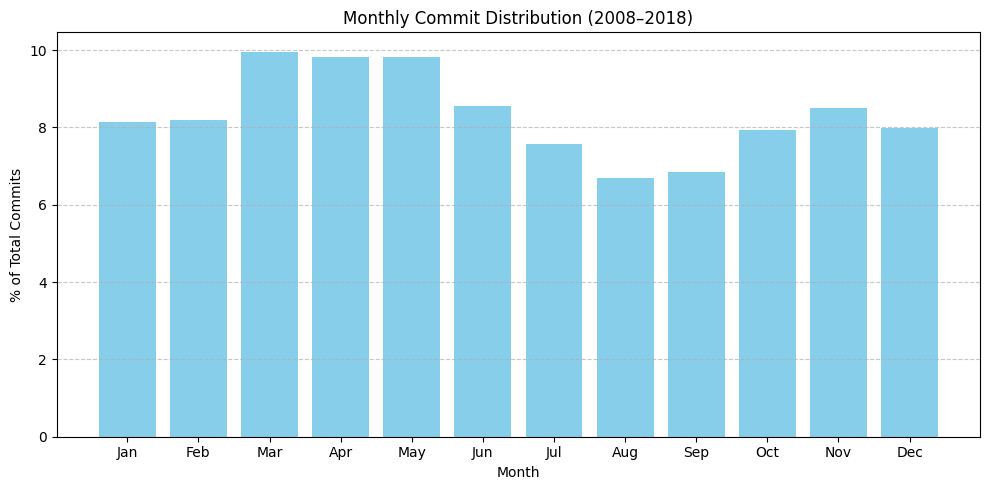

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert PySpark DataFrame to Pandas
monthly_pd = monthly_summary_df.toPandas()

# Sort months in calendar order
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_pd['month'] = pd.Categorical(monthly_pd['month'], categories=month_order, ordered=True)
monthly_pd = monthly_pd.sort_values('month')

# Plot
plt.figure(figsize=(10, 5))
plt.bar(monthly_pd['month'], monthly_pd['percent_of_total'], color='skyblue')
plt.title('Monthly Commit Distribution (2008–2018)')
plt.xlabel('Month')
plt.ylabel('% of Total Commits')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

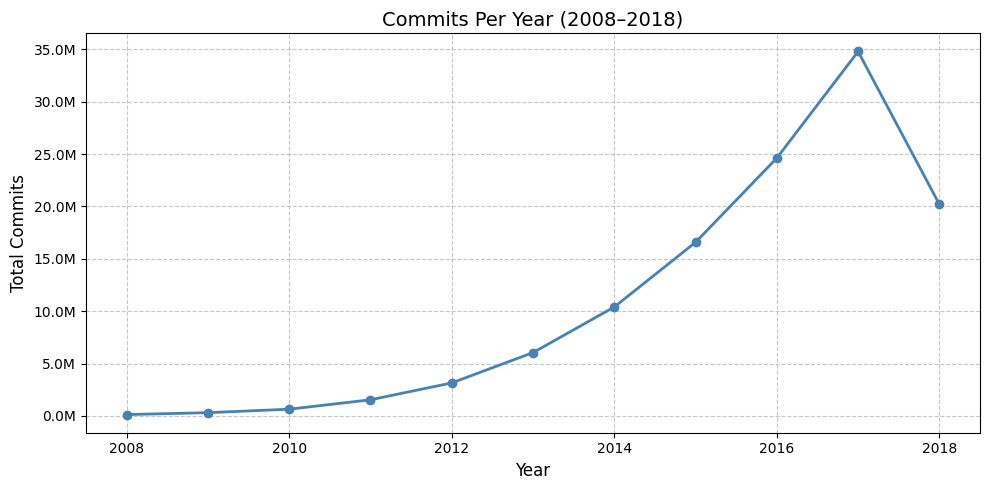

In [24]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Convert to Pandas
yearly_pd = commits_per_year_df.toPandas()
yearly_pd = yearly_pd.sort_values('year')

def millions_formatter(x, pos):
    return f'{x / 1e6:.1f}M'

plt.figure(figsize=(10, 5))
plt.plot(yearly_pd['year'], yearly_pd['total_commits'], marker='o', linewidth=2, color='steelblue')
plt.title('Commits Per Year (2008–2018)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Commits', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.tight_layout()
plt.show()

In [25]:
pip install snowflake-connector-python python-dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.8/70.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.8/84.8 kB 5.1 MB/s eta 0:00:00


In [26]:
from google.colab import userdata
import snowflake.connector

# Establish secure Snowflake connection
conn = snowflake.connector.connect(
    user='bigdata228',
    password=userdata.get('SNOWFLAKE_PASSWORD'),
    account='BFDEIDG-MVB00946',
    warehouse='COMPUTE_WH',
    database='BIGDATA_GITHUB',
    schema='ANALYTICS',
    role='ACCOUNTADMIN'
)

cursor = conn.cursor()

# YEARLY COMMIT SUMMARY
cursor.execute("""
    CREATE OR REPLACE TABLE yearly_commit_summary (
        year INT,
        total_commits BIGINT
    )
""")
cursor.executemany(
    "INSERT INTO yearly_commit_summary (year, total_commits) VALUES (%s, %s)",
    yearly_pd.values.tolist()
)
print("✅ Yearly commit summary saved to Snowflake.")


# MONTHLY COMMIT SUMMARY
cursor.execute("""
    CREATE OR REPLACE TABLE monthly_commit_summary (
        month STRING,
        monthly_commits BIGINT,
        percent_of_total FLOAT
    )
""")
cursor.executemany(
    "INSERT INTO monthly_commit_summary (month, monthly_commits, percent_of_total) VALUES (%s, %s, %s)",
    monthly_pd.values.tolist()
)
print("✅ Monthly commit summary saved to Snowflake.")

# Cleanup
cursor.close()
conn.close()

✅ Yearly commit summary saved to Snowflake.
✅ Monthly commit summary saved to Snowflake.
